In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\User\Anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\User\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you'

In [5]:
num_classes = 100
input_shape = (32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train_shape : {x_train.shape}, y_train_shape : {y_train.shape}")
print(f"x_test_shape : {x_test.shape}, y_test_shape : {y_test.shape}")

169001437/169001437 [==============================] - 36s 0us/step
x_train_shape : (50000, 32, 32, 3), y_train_shape : (50000, 1)
x_test_shape : (10000, 32, 32, 3), y_test_shape : (10000, 1)


In [35]:
batch_size = 256

image_size = 224
patch_size = 32
num_patches = (image_size // patch_size)**2

# D
projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim + 2,
    projection_dim,
]

transformer_layers = 12
mlp_head_units=[2048, 1024]

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor = 0.02),
        layers.RandomZoom(height_factor=0.2, width_factor = 0.2),
    ],
    name = "data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

In [11]:
def mlp(x, hidden_units, dropout_rate):
    
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [31]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1,1,1,1],
            padding = "VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [32]:
import matplotlib.pyplot as plt

image size : 224 X 224
patch size : 32 X 32
Patches per image : 49
Elements per patch : 3072
Shape per patch : (1, 49, 3072)


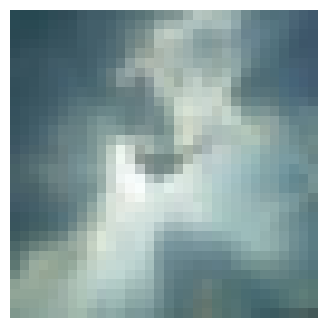

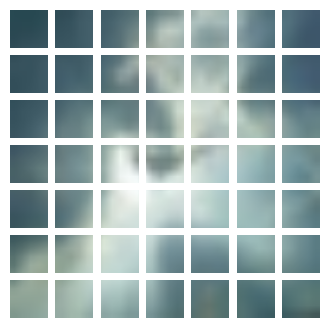

In [33]:
plt.figure(figsize = (4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# 생성자(patch_size) -> 호출(images)
patches = Patches(patch_size)(resized_image)
print(f"image size : {image_size} X {image_size}")
print(f"patch size : {patch_size} X {patch_size}")
print(f"Patches per image : {patches.shape[1]}")
print(f"Elements per patch : {patches.shape[-1]}")
print(f"Shape per patch : {patches.shape}")

# n = 12
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [47]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches 
        
        self.projection = layers.Dense(units= projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches,  
            output_dim = projection_dim
        )
        
    def call(self, patch):
        positions = tf.range(start=0, limit= self.num_patches, delta =1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [61]:
def vit():
    inputs = layers.Input(shape=input_shape)
    
    augmented = data_augmentation(inputs)
    
    patches = Patches(patch_size)(augmented)
    
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        attetion_output = layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = projection_dim,
            dropout = 0.1
        )(x1, x1)
        
        x2 = layers.Add()([attetion_output, encoded_patches])
        
        x3 = layers.LayerNormalization(epsilon= 1e-6)(x2)
        
        x3 = mlp(x3,hidden_units = transformer_units, dropout_rate=0.1)
        
        encoded_patches = layers.Add()([x3,x2])
        
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate=0.5)
    
    logits = layers.Dense(num_classes)(features)
    
    model = keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [62]:
model = vit()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_11[0][0]']               
                                                                                                  
 patches_13 (Patches)           (None, None, 3072)   0           ['data_augmentation[7][0]']      
                                                                                                  
 patch_encoder_7 (PatchEncoder)  (None, 49, 64)      199808      ['patches_13[0][0]']             
                                                                                            

In [ ]:
num_epochs = 20
weight_decay = 0.001
learning_rate = 0.001

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay = weight_decay
)

model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = "accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name = "top-5-accuracy"),
    ],
)

history = model.fit(
    x= x_train, 
    y= y_train,
    batch_size = batch_size,
    epochs=num_epochs,
    validation_split=0.1,
)

Epoch 1/20
